1-hour level data

In [6]:
import pandas as pd
excel_file = 'data/train.xlsx'
data1 = pd.read_excel(excel_file, sheet_name='Sheet1')
data1['date'] = pd.to_datetime(data1['date'])
data2 = pd.read_excel(excel_file, sheet_name='Sheet2')
data2['date'] = pd.to_datetime(data2['date'])
merged_data = pd.merge_asof(data2, data1, on='date', tolerance=pd.Timedelta('1H'))
merged_data.keys()

Index(['date', 'irradiance', 'pri_supp_t', 'pri_back_t', 'pri_flow',
       'sec_supp_t', 'sec_back_t', 'sec_flow', 'outdoor', 'indoor'],
      dtype='object')

10-min level data

In [23]:
import pandas as pd
excel_file = 'data/train.xlsx'
data1 = pd.read_excel(excel_file, sheet_name='Sheet1')
data1['date'] = pd.to_datetime(data1['date'])
data2 = pd.read_excel(excel_file, sheet_name='Sheet2')
data2['date'] = pd.to_datetime(data2['date'])
merged_data = pd.merge_asof(data1, data2, on='date', tolerance=pd.Timedelta('1H'))
merged_data.keys()

Index(['date', 'pri_supp_t', 'pri_back_t', 'pri_flow', 'sec_supp_t',
       'sec_back_t', 'sec_flow', 'outdoor', 'indoor', 'irradiance'],
      dtype='object')

In [24]:
selected_columns = ['pri_supp_t','pri_back_t', 'pri_flow', 'sec_supp_t', 'sec_back_t', 'sec_flow', 'outdoor', 'irradiance', 'indoor']
data_subset = merged_data[selected_columns]
data_subset.dropna(inplace=True)

/tmp/ipykernel_54579/3183275229.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset.dropna(inplace=True)


SVR-single

In [113]:
from sklearn.model_selection import train_test_split
X = data_subset[['pri_supp_t','pri_back_t', 'pri_flow','sec_supp_t', 'sec_back_t', 'sec_flow', 'outdoor', 'irradiance']]
y = data_subset['indoor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)  
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# 创建 SVR 模型
svr = SVR(kernel='rbf')  # 使用径向基函数核，也可以尝试其他核函数
# 训练 SVR 模型
svr.fit(X_train_scaled, y_train)
# 预测测试集数据
pred = svr.predict(X_test_scaled)
# 模型评估
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

In [114]:
r2 = r2_score(y_test, pred)
r2

0.033459110948482085

windowed data

In [ ]:
import numpy as np
import torch
features = ['pri_supp_t','pri_back_t', 'pri_flow','sec_supp_t', 'sec_back_t', 'sec_flow', 'outdoor', 'irradiance']
target = 'indoor'
X = data_subset[features].values
y = data_subset[target].values
time_steps = 4  # 可以根据实际情况调整时间步长

# 创建时间步长的输入数据
X_sequence = []
y_sequence = []
for i in range(len(data_subset) - time_steps):
    X_sequence.append(X[i:i+time_steps])
    y_sequence.append(y[i+time_steps])

X_sequence = np.array(X_sequence, dtype=np.float32)
y_sequence = np.array(y_sequence, dtype=np.float32)

# 划分训练集和测试集
split = int(0.8 * len(X_sequence))
X_train = torch.from_numpy(X_sequence[:split])
y_train = torch.from_numpy(y_sequence[:split])
X_test = torch.from_numpy(X_sequence[split:])
y_test = torch.from_numpy(y_sequence[split:])

LSTM-traininging

In [8]:
import numpy as np
import torch
import torch.nn as nn
class LSTM(nn.Module):    
    def __init__(self,input_size = 5, hidden_size = 8, out_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, dropout=0.2)
        self.linear = nn.Linear(hidden_size,out_size)
        self.init_weights()

    def forward(self,seq):
        h0 = torch.zeros(1,1,self.hidden_size).to(seq.device) 
        c0 = torch.zeros(1,1,self.hidden_size).to(seq.device)
        
        nn.init.orthogonal_(h0)
        nn.init.orthogonal_(c0)

        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), (h0,c0))
        pred = self.linear(lstm_out.view(len(seq),-1))
        
        return pred[-1]
    
    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param)

/home/yuleliu/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [266]:
torch.manual_seed(42)
model = LSTM(input_size=5)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model

/home/yuleliu/miniconda3/lib/python3.10/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTM(
  (lstm): LSTM(5, 8, dropout=0.2)
  (linear): Linear(in_features=8, out_features=1, bias=True)
)

In [267]:
epochs = 50
future = 40
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for i in range(epochs):
    for seq, labels  in zip(X_train, y_train):
        optimizer.zero_grad()
        seq, labels = seq.to(device), labels.to(device)
        y_pred = model(seq)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {i} Loss: {loss.item()}")
    
    # preds = X[-time_steps:].tolist()
    # for f in range(future):
    #     seq = torch.FloatTensor(preds[-time_steps:]).to(device)
    #     with torch.no_grad():
    #         model.reset_hidden(device)
    #         preds.append(model(seq).item())
        
    # loss = criterion(torch.tensor(preds[-time_steps:]), y[760:])
    # print(f"Performance on test range: {loss}")
    
    # plt.figure(figsize=(12,4))
    # plt.xlim(700,801)
    # plt.grid(True)
    # plt.plot(y.numpy(),color='#8000ff')
    # plt.plot(range(760,800),preds[time_steps:],color='#ff8000')
    # plt.show()

/home/yuleliu/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.013126863166689873
Epoch 1 Loss: 0.012063655070960522
Epoch 2 Loss: 0.009419387206435204
Epoch 3 Loss: 0.009813651442527771
Epoch 4 Loss: 0.01174815371632576
Epoch 5 Loss: 0.010223710909485817
Epoch 6 Loss: 0.011884995736181736
Epoch 7 Loss: 0.008640210144221783
Epoch 8 Loss: 0.009858672507107258
Epoch 9 Loss: 0.009393488988280296
Epoch 10 Loss: 0.012476903386414051
Epoch 11 Loss: 0.00964545737951994
Epoch 12 Loss: 0.011680442839860916
Epoch 13 Loss: 0.008180564269423485
Epoch 14 Loss: 0.009774765931069851
Epoch 15 Loss: 0.011620738543570042
Epoch 16 Loss: 0.012070359662175179
Epoch 17 Loss: 0.01139933243393898
Epoch 18 Loss: 0.010499009862542152
Epoch 19 Loss: 0.01041475124657154
Epoch 20 Loss: 0.010462299920618534
Epoch 21 Loss: 0.012299004942178726
Epoch 22 Loss: 0.010896306484937668
Epoch 23 Loss: 0.009682207368314266
Epoch 24 Loss: 0.008795500732958317
Epoch 25 Loss: 0.008098654448986053
Epoch 26 Loss: 0.011391595005989075
Epoch 27 Loss: 0.010445918887853622
Epoch 

KeyboardInterrupt: 

In [268]:
model.eval()
pred = []
with torch.no_grad():
    for seq, labels in zip(X_test, y_test):
        seq, labels = seq.to(device), labels.to(device)
        y_pred = model(seq)
        pred.append(float(y_pred))
        test_loss = criterion(y_pred, labels)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0190


SVR-windowed

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
features = ['pri_supp_t','pri_back_t', 'pri_flow','sec_supp_t', 'sec_back_t', 'sec_flow', 'outdoor', 'irradiance']
target = 'indoor'
X = data_subset[features].values
y = data_subset[target].values
time_steps = 16  # 可以根据实际情况调整时间步长

# 创建时间步长的输入数据
X_sequence = []
y_sequence = []
for i in range(len(data_subset) - time_steps):
    X_sequence.append(X[i:i+time_steps])
    y_sequence.append(y[i+time_steps])

X_sequence = np.array(X_sequence, dtype=np.float32)
y_sequence = np.array(y_sequence, dtype=np.float32)

# 划分训练集和测试集
split = int(0.8 * len(X_sequence))
X_train = torch.from_numpy(X_sequence[:split])
y_train = torch.from_numpy(y_sequence[:split])
X_test = torch.from_numpy(X_sequence[split:])
y_test = torch.from_numpy(y_sequence[split:])
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape( X_train.shape[0], -1))
X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0],-1))

# 创建 SVR 模型
svr = SVR(kernel='rbf')  # 使用径向基函数核，也可以尝试其他核函数
# 训练 SVR 模型
svr.fit(X_train_scaled, y_train)
# 预测测试集数据
pred = svr.predict(X_test_scaled)
# 模型评估
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

MLP-windowed

In [25]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
features = ['pri_supp_t','pri_back_t', 'pri_flow','sec_supp_t', 'sec_back_t', 'sec_flow', 'outdoor', 'irradiance']
target = 'indoor'
X = data_subset[features].values
y = data_subset[target].values
time_steps = 64  # 可以根据实际情况调整时间步长

# 创建时间步长的输入数据
X_sequence = []
y_sequence = []
for i in range(len(data_subset) - time_steps):
    X_sequence.append(X[i:i+time_steps])
    y_sequence.append(y[i+time_steps])

X_sequence = np.array(X_sequence, dtype=np.float32)
y_sequence = np.array(y_sequence, dtype=np.float32)

# 划分训练集和测试集
split = int(0.9 * len(X_sequence))
X_train = torch.from_numpy(X_sequence[:split])
y_train = torch.from_numpy(y_sequence[:split]).float()
X_test = torch.from_numpy(X_sequence[split:])
y_test = torch.from_numpy(y_sequence[split:]).float()
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train.reshape( X_train.shape[0], -1))
# X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0],-1))

# 将 3D 特征数据整形为 2D，用于 SVR 的拟合和预测


In [27]:
X_train.shape

torch.Size([10183, 64, 8])

In [128]:
tokenizer = nn.Linear(X_train[0].shape[1] ,  128)
tokenized_x = tokenizer(X_train[0])
tokenizer(X_train[0]).shape

torch.Size([6, 128])

In [28]:
pair = lambda x: x if isinstance(x, tuple) else (x, x)
from functools import partial
from torch import nn 
class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x)) + x

def FeedForward(dim, expansion_factor = 4, dropout = 0., dense = nn.Linear):
    inner_dim = int(dim * expansion_factor)
    return nn.Sequential(
        dense(dim, inner_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        dense(inner_dim, dim),
        nn.Dropout(dropout)
    )

class MLPMixer(nn.Module):
    def __init__(self, depth,feaure_in,  dim, num_patches, expansion_factor = 4, expansion_factor_token = 0.5, dropout = 0., batched=True):
        super(MLPMixer, self).__init__()
        self.device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
        self.chan_first, self.chan_last = partial(nn.Conv1d, kernel_size = 1), nn.Linear
        self.tokenizer = nn.Linear(feaure_in,  dim)
        self.mixer = nn.Sequential(*[nn.Sequential(
            PreNormResidual(dim, FeedForward(num_patches, expansion_factor, dropout, self.chan_first)),
            PreNormResidual(dim, FeedForward(dim, expansion_factor_token, dropout, self.chan_last))
        ) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.predictor = nn.Linear(dim, 1)
        self.batched = batched

    def forward(self, x):
        x = x.to(self.device)
        x = self.tokenizer(x)
        x = self.mixer(x)
        x = x.mean(dim=1) if self.batched else  x.mean(dim=0)
        y = self.predictor(x)
        return y

In [29]:
from sklearn.metrics import mean_squared_error, r2_score
d = 16
dim=256
dropout = 0.1
model = MLPMixer(depth=d, feaure_in=X_train[0].shape[1], dim = dim, num_patches=X_train[0].shape[0], dropout=dropout)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=0.001)  # 可以根据需要调整学习率和优化器
model.to(device)
# 训练模型
num_epochs = 200
batch_size = 400

# 创建 DataLoader
train_loader = DataLoader(range(len(X_train)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(range(len(X_test)), batch_size=batch_size, shuffle=False)
loss_min = 100
model_save = None
patience = 0
for epoch in range(num_epochs):
    model.train()
    if patience >=30:
        print('early stop')
        break
    for perm in train_loader:
        optimizer.zero_grad()
        outputs = model(X_train[perm])
        y = y_train[perm].to(device)
        loss = criterion(outputs.view(-1), y)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    if loss.item()< loss_min:
        model_save = model
        loss_min = loss.item()
        patience=0
    else:
        patience+=1

Epoch [20/200], Loss: 0.3754
Epoch [40/200], Loss: 0.1984
Epoch [60/200], Loss: 0.9399
early stop


In [30]:
loss_min

0.13230645656585693

In [ ]:
import json
import torch
config = json.load(open('/home/yuleliu/art/model_weight/model_config.json','r'))
model = MLPMixer(**config,batched=True)
model.to(model.device)
model.load_state_dict(torch.load('/home/yuleliu/art/model_weight/model_10m_step64_dropout_0.1_dim_256_layer_16_test_0.274868298345625.pth'))
model_save = model
criterion = nn.MSELoss()
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [43]:
from sklearn.metrics import mean_squared_error, r2_score
model = model_save
# 在测试集上进行预测
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs.view(-1), y_test.to(device))
    print(f'R2 score is {r2_score(y_test, test_outputs.view(-1).cpu())}')
    print(f'Test Loss: {test_loss.item():.4f}')
pred = test_outputs.to('cpu').numpy().flatten()
torch.save(model.state_dict(), f'model_weight/model_step{time_steps}_dropout_{dropout}_dim_{dim}_layer_{d}_test_{r2_score(y_test, test_outputs.view(-1).cpu())}.pth')
l = y_test

R2 score is 0.1226286306417057
Test Loss: 0.2509


In [172]:
model = model_save
model.eval()
with torch.no_grad():
    test_outputs = model(X_train)
    test_loss = criterion(test_outputs.view(-1), y_train.to(device))
    print(f'R2 score is {r2_score(y_train, test_outputs.view(-1).cpu())}')
    print(f'Test Loss: {test_loss.item():.4f}')
pred = test_outputs.to('cpu').numpy().flatten()
l = y_train

R2 score is -2.027457702170393
Test Loss: 1.0651


Draw result

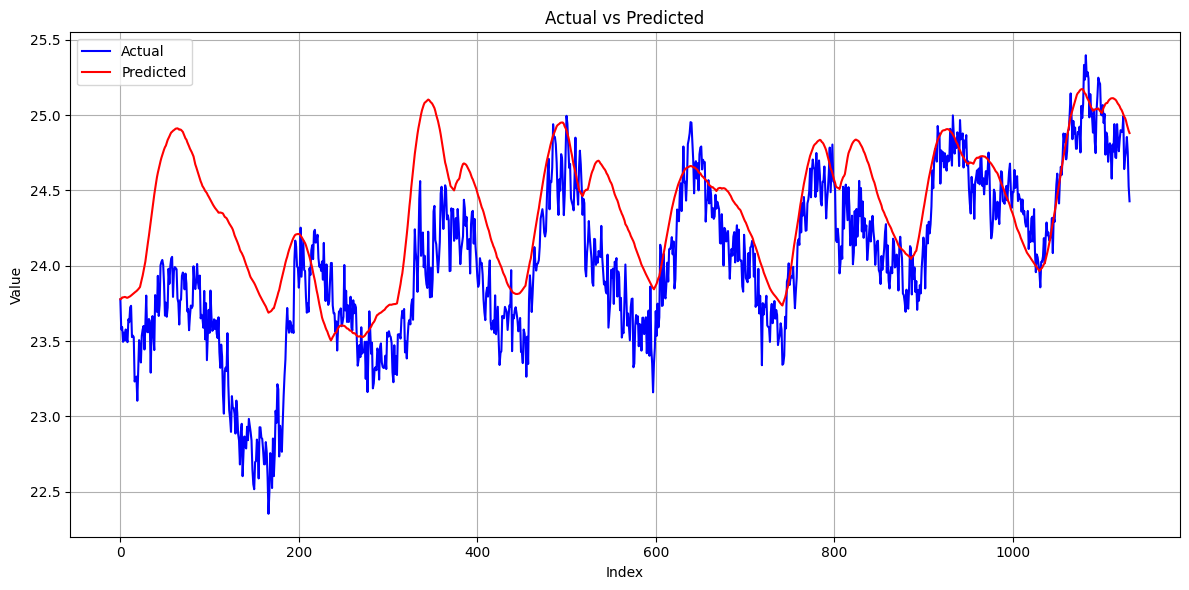

In [33]:
import matplotlib.pyplot as plt

# 假设 y_test 和 y_pred 是真实值和预测值
plt.figure(figsize=(12, 6))

# 画出真实值 y_test
plt.plot(l, label='Actual', color='blue')

# 画出预测值 y_pred
plt.plot(pred, label='Predicted', color='red')

plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


In [22]:
torch.save(model.state_dict(), 'model_step64_layer_16_test_0.54.pth')

Get real temp

In [53]:
def get_seq(excel_file):
    import pandas as pd
    data1 = pd.read_excel(excel_file, sheet_name='Sheet1')
    data1['date'] = pd.to_datetime(data1['date'])
    data2 = pd.read_excel(excel_file, sheet_name='Sheet2')
    data2['date'] = pd.to_datetime(data2['date'])
    merged_data = pd.merge_asof(data1, data2, on='date', tolerance=pd.Timedelta('1H'))
    merged_data.keys()
    selected_columns = ['pri_supp_t','pri_back_t', 'pri_flow', 'sec_supp_t', 'sec_back_t', 'sec_flow', 'outdoor', 'irradiance']
    data_subset = merged_data[selected_columns]
    data_subset.dropna(inplace=True)
    X = data_subset.values
    return X

def load_test_data(time_steps):
    X1, X2 = get_seq('data/train.xlsx'), get_seq('data/test.xlsx')
    X = np.concatenate([X1[-64:], X2], axis=0)
    X_sequence = []
    tmp = []
    for i in range(len(X) - time_steps):
        tmp.append(X[i:i+time_steps])
        X_sequence.append((np.concatenate(X[i:i+time_steps])))
    X_sequence = np.array(X_sequence, dtype=np.float32)
    return X_sequence, np.array(tmp, dtype=np.float32 )


test_real = load_test_data(64)[1]

/tmp/ipykernel_54579/2728837999.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset.dropna(inplace=True)
/tmp/ipykernel_54579/2728837999.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset.dropna(inplace=True)


In [54]:
test_real = torch.from_numpy(test_real)
from sklearn.metrics import mean_squared_error, r2_score
model = model_save
# 在测试集上进行预测
model.eval()
with torch.no_grad():
    test_outputs = model(test_real)
pred = test_outputs.to('cpu').numpy().flatten()

In [55]:
pred.shape

(4747,)

In [56]:
pd.DataFrame(pred).to_excel('tem_10m.xlsx')

In [60]:
df = pd.DataFrame([[1],[2]])
df['new'] = [1,2]

In [63]:
pd.read_csv('./data/test.xlsx')[['date']]

ParserError: Error tokenizing data. C error: Expected 3 fields in line 9, saw 4
